## Comparing different Activation Functions

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from typing import Type, Dict, Callable

In [9]:
class Config:
    batch_size = 128
    num_epochs = 10  # Reduced for multiple activation function testing
    initial_learning_rate = 0.001
    weight_decay = 1e-5
    early_stopping_patience = 5
    dropout_rate = 0.4

# Activation Functions to be compared
ACTIVATION_FUNCTIONS: Dict[str, Callable] = {
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU(),
    'ELU': nn.ELU(),
    'GELU': nn.GELU(),
    'Tanh': nn.Tanh(),
    'SELU': nn.SELU()
}

In [10]:
class ImprovedNet(nn.Module):
    def __init__(self, activation_fn: nn.Module, dropout_rate=0.4):
        super(ImprovedNet, self).__init__()
        self.activation = activation_fn
        
        self.fc1 = nn.Linear(28*28, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(dropout_rate)
        
        self.res1 = nn.Linear(28*28, 512)
        self.res2 = nn.Linear(256, 128)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        identity = x
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.dropout(x)
        res1 = self.res1(identity)  
        x = x + res1  
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        identity2 = x  
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.dropout(x)
        res2 = self.res2(identity2)  
        x = x + res2  
        
        x = self.fc4(x)
        return x

In [11]:
class ActivationComparison:
    def __init__(self, device):
        self.device = device
        self.train_loader, self.test_loader = get_data_loaders(Config.batch_size)
        self.results = {}
        
    def train_model(self, activation_name: str, activation_fn: nn.Module) -> Dict:
        print(f"\nTraining with {activation_name}")
        model = ImprovedNet(activation_fn=activation_fn).to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), 
                              lr=Config.initial_learning_rate, 
                              weight_decay=Config.weight_decay)
        
        history = {
            'train_loss': [],
            'train_acc': [],
            'test_loss': [],
            'test_acc': []
        }
        
        for epoch in range(Config.num_epochs):
            # Training
            model.train()
            train_loss, train_acc = 0.0, 0.0
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                train_acc += torch.sum(preds == labels).item()
            
            train_loss /= len(self.train_loader)
            train_acc /= len(self.train_loader.dataset)
            
            # Testing
            model.eval()
            test_loss, test_acc = 0.0, 0.0
            with torch.no_grad():
                for inputs, labels in self.test_loader:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    test_loss += loss.item()
                    _, preds = torch.max(outputs, 1)
                    test_acc += torch.sum(preds == labels).item()
            
            test_loss /= len(self.test_loader)
            test_acc /= len(self.test_loader.dataset)
            
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            
            print(f"Epoch {epoch+1}/{Config.num_epochs} - "
                  f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - "
                  f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.4f}")
        
        return history
    
    def compare_activations(self):
        for name, activation_fn in ACTIVATION_FUNCTIONS.items():
            self.results[name] = self.train_model(name, activation_fn)
    
    def plot_comparison(self):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        for activation_name, history in self.results.items():
            # Training Loss
            ax1.plot(history['train_loss'], label=activation_name)
            ax1.set_title('Training Loss')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.legend()
            
            # Test Loss
            ax2.plot(history['test_loss'], label=activation_name)
            ax2.set_title('Test Loss')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            ax2.legend()
            
            # Training Accuracy
            ax3.plot(history['train_acc'], label=activation_name)
            ax3.set_title('Training Accuracy')
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Accuracy')
            ax3.legend()
            
            # Test Accuracy
            ax4.plot(history['test_acc'], label=activation_name)
            ax4.set_title('Test Accuracy')
            ax4.set_xlabel('Epoch')
            ax4.set_ylabel('Accuracy')
            ax4.legend()
        
        plt.tight_layout()
        plt.show()

    def plot_final_metrics(self):
        final_metrics = {
            'Test Accuracy': {name: history['test_acc'][-1] for name, history in self.results.items()},
            'Train Accuracy': {name: history['train_acc'][-1] for name, history in self.results.items()}
        }
        
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(ACTIVATION_FUNCTIONS))
        width = 0.35
        
        ax.bar(x - width/2, final_metrics['Train Accuracy'].values(), width, label='Train Accuracy')
        ax.bar(x + width/2, final_metrics['Test Accuracy'].values(), width, label='Test Accuracy')
        
        ax.set_ylabel('Accuracy')
        ax.set_title('Final Training and Test Accuracy by Activation Function')
        ax.set_xticks(x)
        ax.set_xticklabels(ACTIVATION_FUNCTIONS.keys(), rotation=45)
        ax.legend()
        
        plt.tight_layout()
        plt.show()

     def plot_final_metrics(self):
        final_metrics = {
            'Test Accuracy': {name: history['test_acc'][-1] for name, history in self.results.items()},
            'Train Accuracy': {name: history['train_acc'][-1] for name, history in self.results.items()}
        }
        
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(ACTIVATION_FUNCTIONS))
        width = 0.35
        
        ax.bar(x - width/2, final_metrics['Train Accuracy'].values(), width, label='Train Accuracy')
        ax.bar(x + width/2, final_metrics['Test Accuracy'].values(), width, label='Test Accuracy')
        
        ax.set_ylabel('Accuracy')
        ax.set_title('Final Training and Test Accuracy by Activation Function')
        ax.set_xticks(x)
        ax.set_xticklabels(ACTIVATION_FUNCTIONS.keys(), rotation=45)
        ax.legend()
        
        plt.tight_layout()
        plt.show()

    def get_data_loaders(batch_size):
        # Data transforms
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081))
        ])
        
        # Load datasets
        train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root='.', train=False, download=True, transform=transform)
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
        
        return train_loader, test_loader

        

Using device: cuda

Training with ReLU
Epoch 1/10 - Train Loss: 0.2884 - Train Acc: 0.9132 - Test Loss: 0.1295 - Test Acc: 0.9589
Epoch 2/10 - Train Loss: 0.1623 - Train Acc: 0.9503 - Test Loss: 0.0976 - Test Acc: 0.9690
Epoch 3/10 - Train Loss: 0.1327 - Train Acc: 0.9597 - Test Loss: 0.0909 - Test Acc: 0.9714
Epoch 4/10 - Train Loss: 0.1169 - Train Acc: 0.9629 - Test Loss: 0.0874 - Test Acc: 0.9723
Epoch 5/10 - Train Loss: 0.1054 - Train Acc: 0.9671 - Test Loss: 0.0793 - Test Acc: 0.9738
Epoch 6/10 - Train Loss: 0.0950 - Train Acc: 0.9700 - Test Loss: 0.0778 - Test Acc: 0.9776
Epoch 7/10 - Train Loss: 0.0883 - Train Acc: 0.9721 - Test Loss: 0.0733 - Test Acc: 0.9769
Epoch 8/10 - Train Loss: 0.0816 - Train Acc: 0.9733 - Test Loss: 0.0791 - Test Acc: 0.9753
Epoch 9/10 - Train Loss: 0.0782 - Train Acc: 0.9740 - Test Loss: 0.0779 - Test Acc: 0.9758
Epoch 10/10 - Train Loss: 0.0745 - Train Acc: 0.9757 - Test Loss: 0.0775 - Test Acc: 0.9762

Training with LeakyReLU
Epoch 1/10 - Train Loss: 

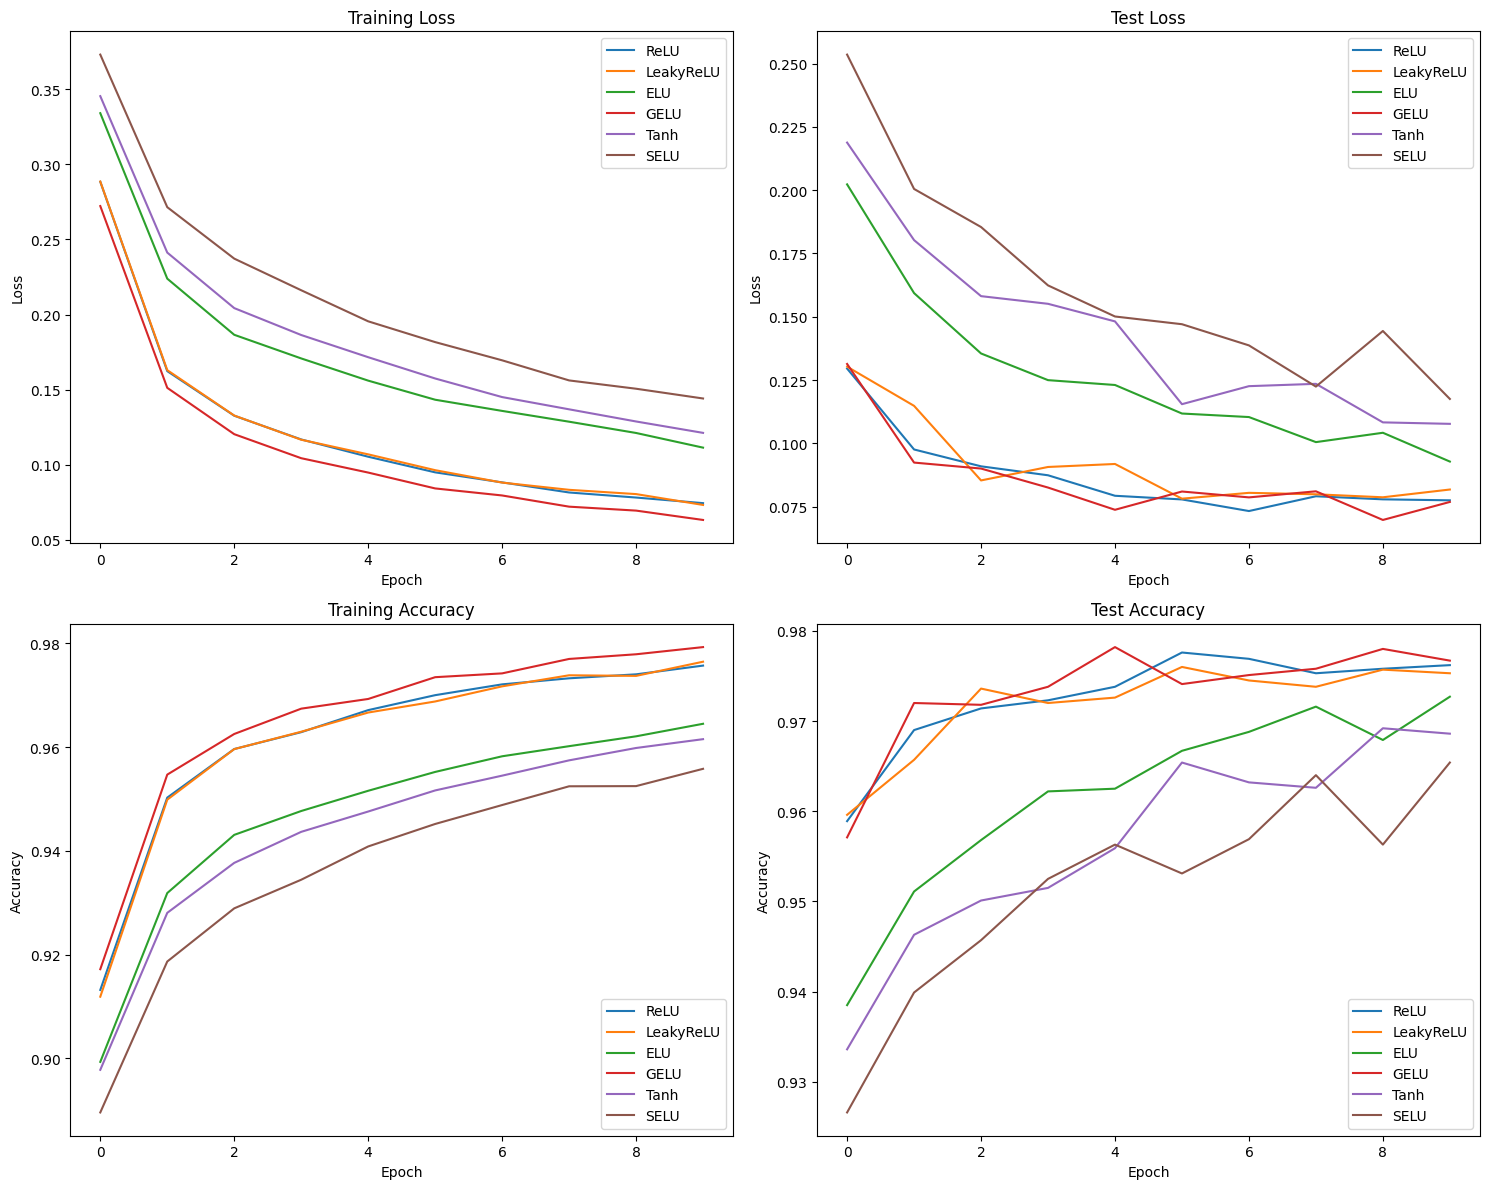

AttributeError: 'ActivationComparison' object has no attribute 'plot_final_metrics'

In [13]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize comparison
    comparison = ActivationComparison(device)
    
    # Run comparison
    comparison.compare_activations()
    
    # Plot results
    comparison.plot_comparison()

if __name__ == "__main__":
    main()